In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import spacy
import transformers
import torch

from datasets import Dataset
from hdbscan import HDBSCAN
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    precision_score,
    recall_score
)
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM
)
from umap import UMAP
from wordcloud import WordCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Read data

In [3]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_data_llava.json')
test_data_path = os.path.join(data_dir, 'test_data_llava.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'image_name': [], 'caption': [], 'label': []}
    for key, value in data.items():
      data_formated['image_name'].append(key)
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
test_df = generate_df_from_json(test_data_path)
train_df = pd.concat([train_df, test_df], axis=0)
train_df['Label'] = train_df['label'].replace(id2label)
test_df['Label'] = test_df['label'].replace(id2label)

print(train_df.shape)
#train_data = Dataset.from_pandas(train_df).train_test_split(test_size=0.15, seed=4999)
#test_data = Dataset.from_pandas(train_df)
#print(train_data)

(960, 4)


## Generate embeddings

In [4]:
embedding_model = SentenceTransformer("all-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("paraphrase-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to('cuda')

def generate_embeddings(df: pd.DataFrame, text_col: str):
    sentences = df[text_col].tolist()
    embeddings = embedding_model.encode(sentences)

    return embeddings
    
train_embeddings = generate_embeddings(train_df, 'caption')
test_embeddings = generate_embeddings(test_df, 'caption')

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Dimensionality reduction (UMAP)

We are going to reduce dimensonality:
1. For documents visualization, with 2 dimensions
2. For documents clustering, with more dimensions

### For documents visualization

In [4]:
viz_reducer = UMAP(n_neighbors=15, n_components=2, metric='cosine')
viz_train_reduced = viz_reducer.fit_transform(train_embeddings)

<Axes: xlabel='x', ylabel='y'>

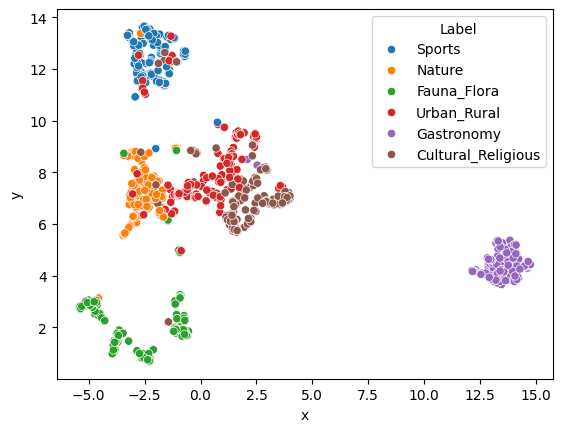

In [5]:
train_df['x'] = viz_train_reduced[:, 0]
train_df['y'] = viz_train_reduced[:, 1]
sns.scatterplot(
    train_df, x='x', y='y', 
    hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)

### For clustering

In [15]:
reducer = UMAP(n_neighbors=15, n_components=20, metric='cosine')
train_reduced = reducer.fit_transform(train_embeddings)
test_reduced = reducer.transform(test_embeddings)

## Clustering

### HDBSCAN

In [16]:
clusterer = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='leaf', prediction_data=True, approx_min_span_tree=False)
clusterer.fit(train_reduced)

HDBSCAN(approx_min_span_tree=False, cluster_selection_method='leaf',
        min_cluster_size=20, prediction_data=True)

/tmp/ipykernel_74245/1165245163.py:2: UserWarning: 
The palette list has fewer values (10) than needed (13) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(


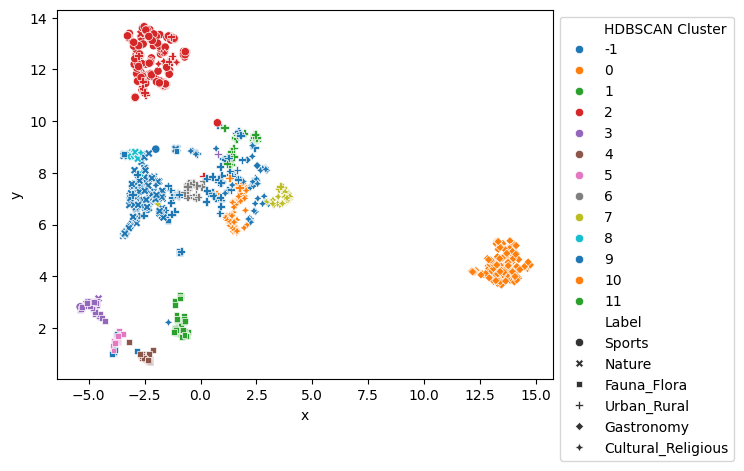

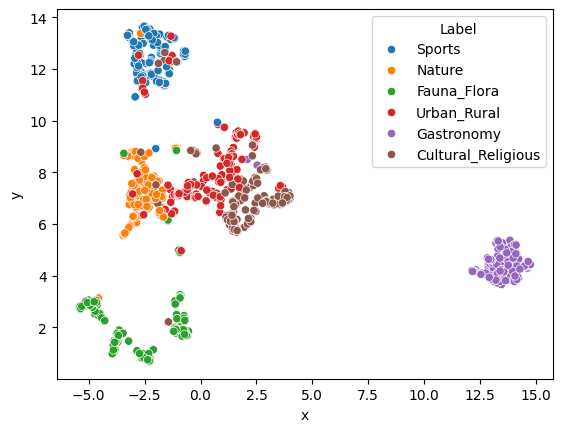

In [17]:
train_df['HDBSCAN Cluster'] = clusterer.labels_
ax = sns.scatterplot(
    train_df, x='x', y='y', hue='HDBSCAN Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=10)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

<Axes: ylabel='$\\lambda$ value'>

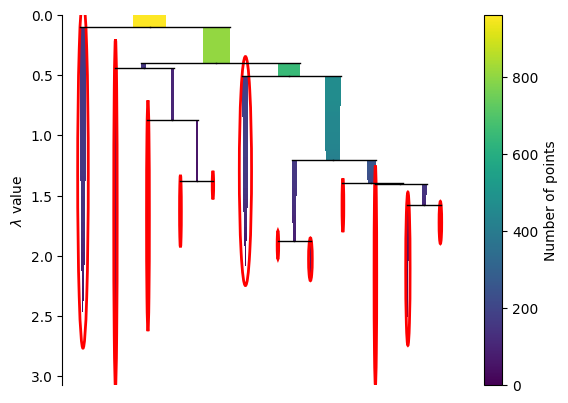

In [18]:
clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 8)
)

### KMeans

In [72]:
kmeans_clusterer = AgglomerativeClustering(n_clusters=6)#, n_init=20, max_iter=10000)
kmeans_clusterer.fit(train_reduced)

AgglomerativeClustering(n_clusters=6)

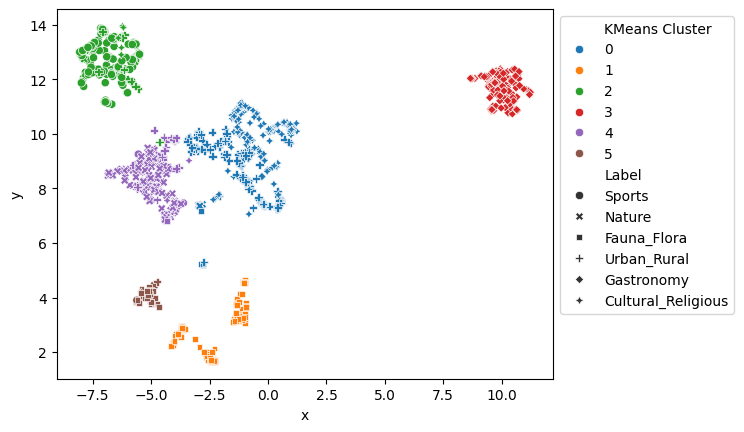

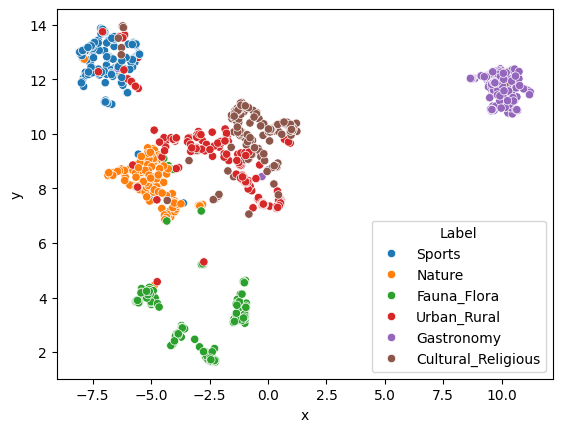

In [73]:
train_df['KMeans Cluster'] = kmeans_clusterer.labels_
ax=sns.scatterplot(
    train_df, x='x', y='y', hue='KMeans Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=6)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

## Clusters BoW

Cluster -1


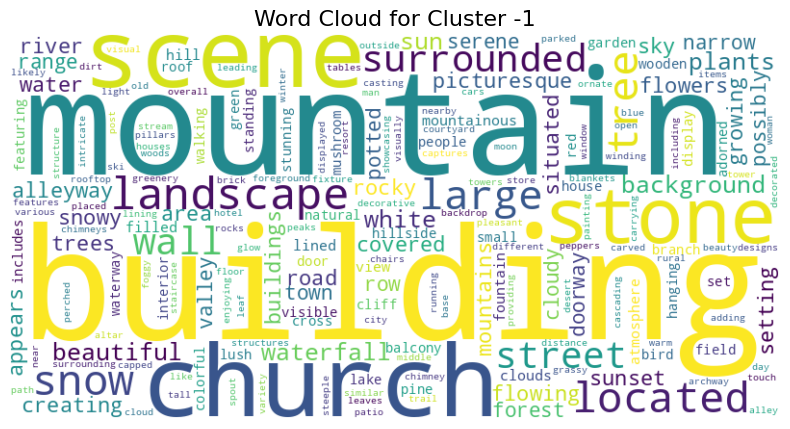

building: 0.3193
mountain: 0.2835
church: 0.2017
scene: 0.1839
stone: 0.1819
landscape: 0.1717
tree: 0.1664
snow: 0.1558
located: 0.1548
large: 0.1489


Cluster 0


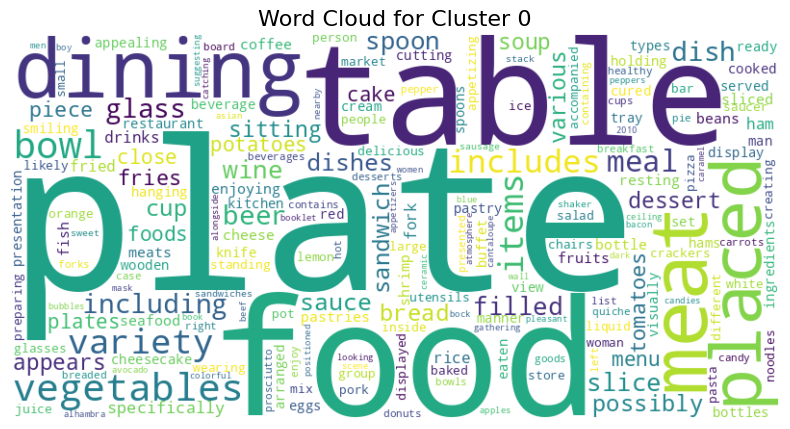

plate: 0.6338
food: 0.4051
table: 0.3335
dining: 0.2260
meat: 0.2127
placed: 0.1666
vegetables: 0.1507
bowl: 0.1418
variety: 0.1195
items: 0.1147


Cluster 1


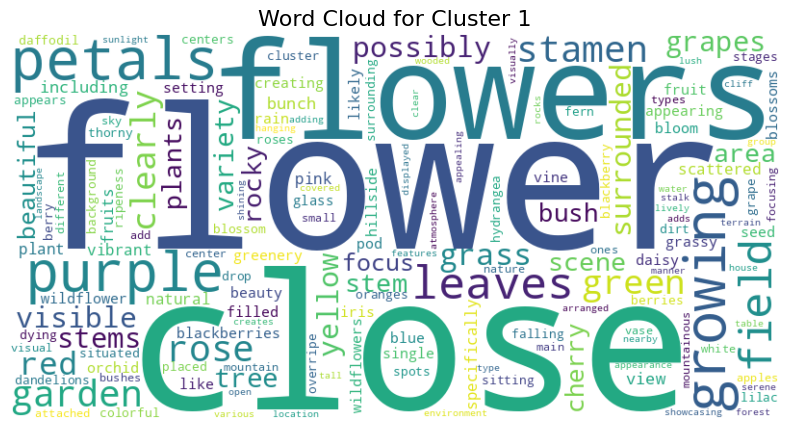

flower: 0.4508
close: 0.4153
flowers: 0.2802
petals: 0.2756
growing: 0.2629
purple: 0.2526
leaves: 0.1645
field: 0.1571
garden: 0.1297
rose: 0.1272


Cluster 2


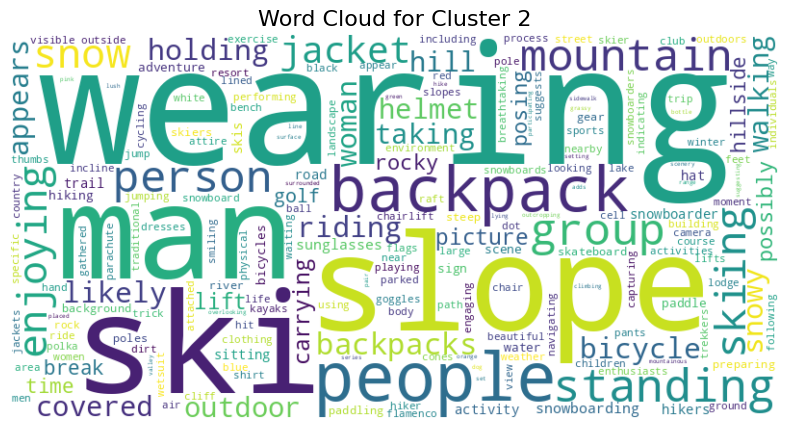

wearing: 0.3766
ski: 0.2590
slope: 0.2417
man: 0.2319
people: 0.2319
backpack: 0.2202
standing: 0.2028
group: 0.1927
person: 0.1839
mountain: 0.1804


Cluster 3


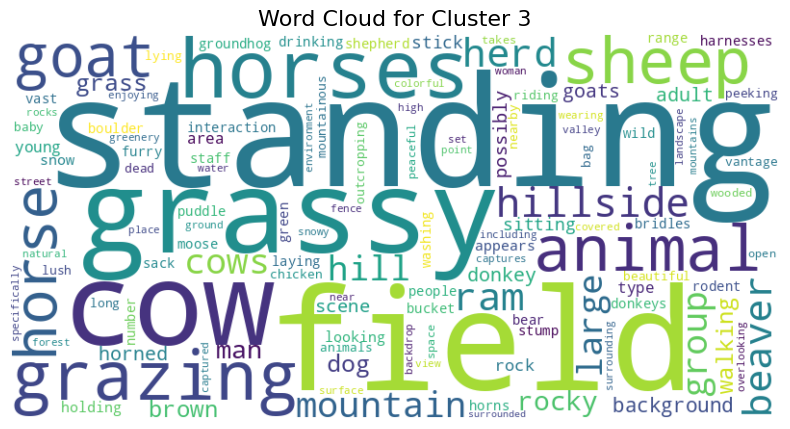

standing: 0.3932
field: 0.3399
grassy: 0.3229
cow: 0.3210
horses: 0.2568
grazing: 0.2215
animal: 0.1926
sheep: 0.1926
goat: 0.1605
horse: 0.1605


Cluster 4


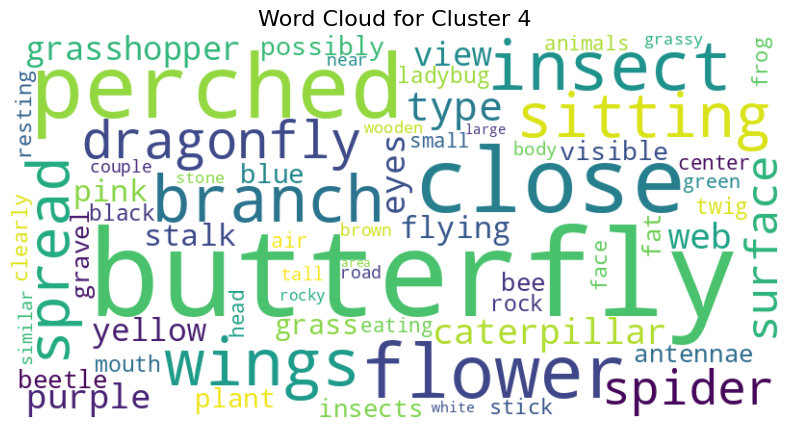

butterfly: 0.6755
close: 0.3353
perched: 0.3200
flower: 0.2184
insect: 0.1820
wings: 0.1689
branch: 0.1614
sitting: 0.1423
spread: 0.1291
dragonfly: 0.1267


Cluster 5


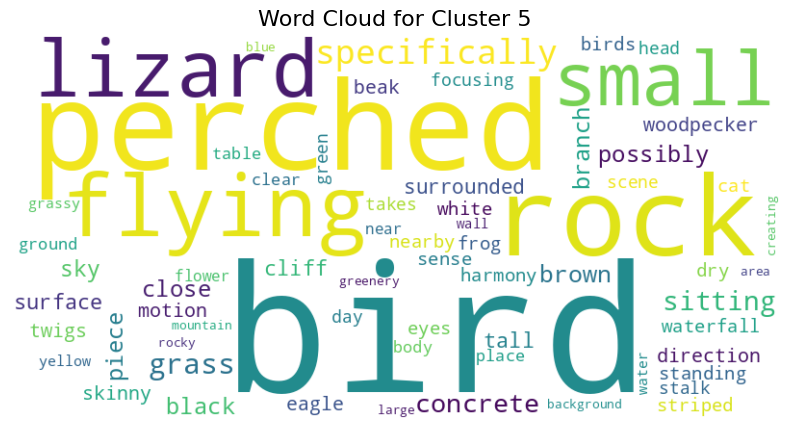

bird: 0.7736
perched: 0.3090
rock: 0.2415
flying: 0.2058
lizard: 0.1794
small: 0.1582
specifically: 0.1547
grass: 0.1125
sitting: 0.0945
concrete: 0.0897


Cluster 6


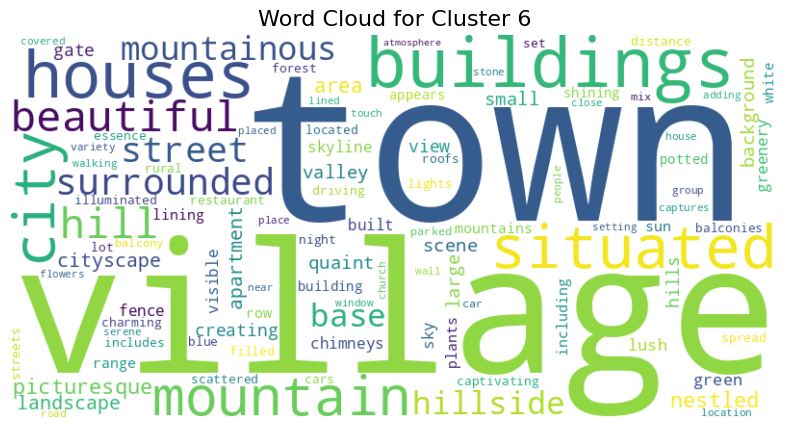

town: 0.4716
village: 0.3644
buildings: 0.2731
houses: 0.2415
situated: 0.2146
city: 0.1967
mountain: 0.1828
beautiful: 0.1707
hill: 0.1609
surrounded: 0.1588


Cluster 7


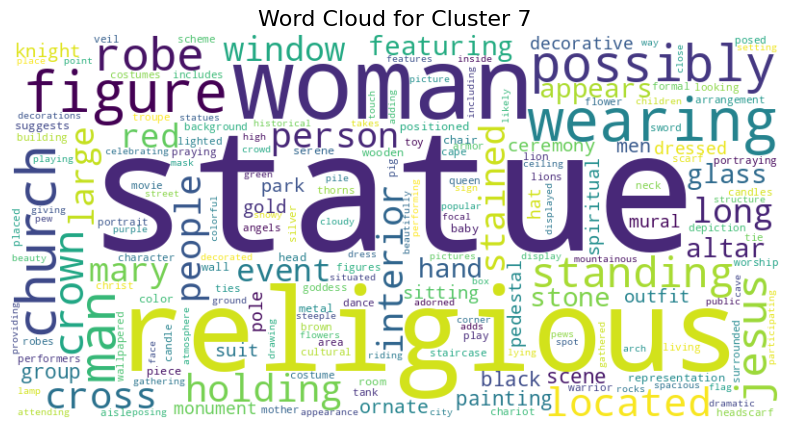

statue: 0.7445
religious: 0.2686
woman: 0.1958
wearing: 0.1953
figure: 0.1752
church: 0.1587
man: 0.1429
possibly: 0.1420
robe: 0.1168
jesus: 0.1007


Cluster 8


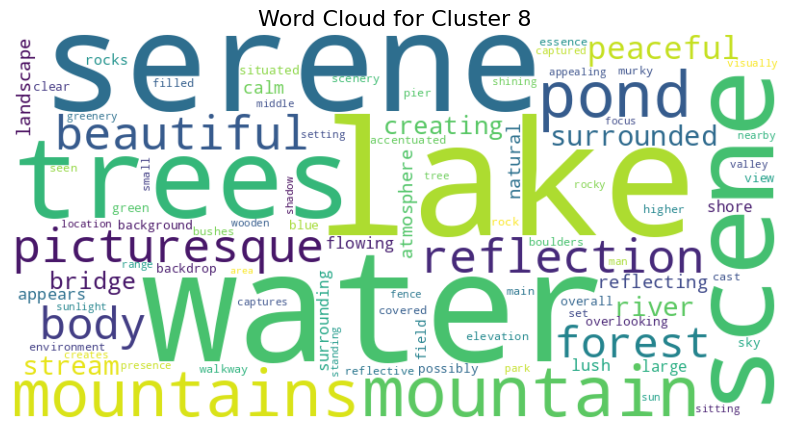

lake: 0.4013
water: 0.3809
serene: 0.3446
scene: 0.2249
trees: 0.2177
mountain: 0.2013
mountains: 0.1814
pond: 0.1773
picturesque: 0.1772
beautiful: 0.1745


Cluster 9


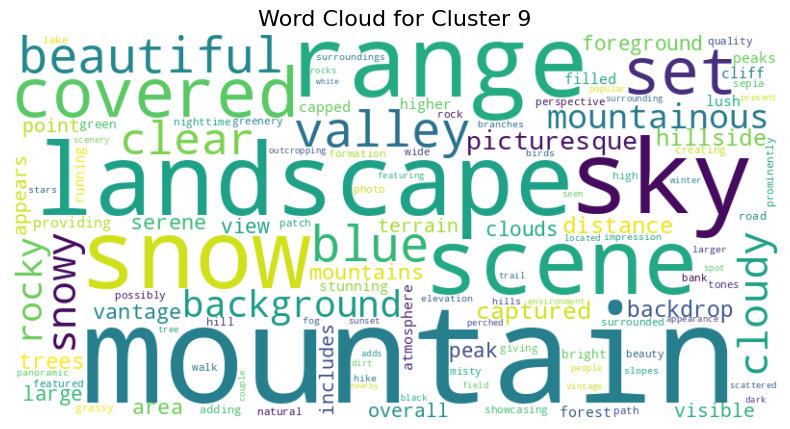

mountain: 0.5789
sky: 0.2937
landscape: 0.2755
range: 0.2755
snow: 0.2559
scene: 0.2309
covered: 0.2012
set: 0.1788
valley: 0.1618
beautiful: 0.1599


Cluster 10


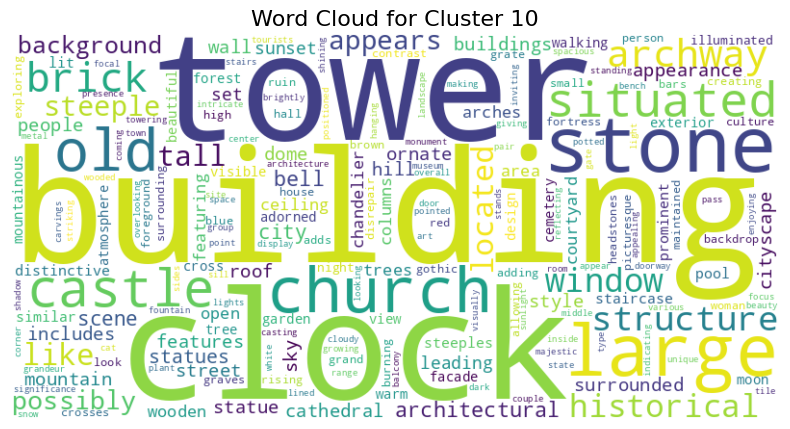

building: 0.5220
clock: 0.4925
tower: 0.4925
stone: 0.2032
large: 0.1907
church: 0.1761
old: 0.1504
castle: 0.1217
situated: 0.1184
brick: 0.0788


Cluster 11


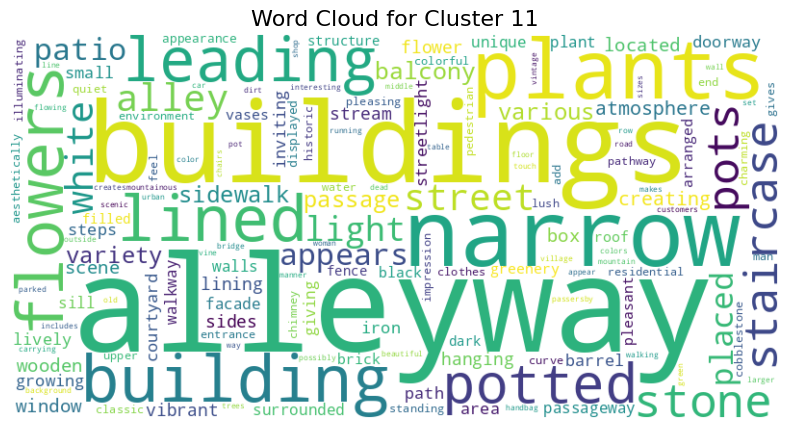

alleyway: 0.6550
buildings: 0.4374
narrow: 0.2964
plants: 0.2243
building: 0.1604
flowers: 0.1604
lined: 0.1555
leading: 0.1423
potted: 0.1361
stone: 0.0985




In [19]:
# Step 1: Combine all documents in the same cluster into a single document
clustered_docs = train_df.groupby('HDBSCAN Cluster')['caption'].apply(' '.join).reset_index()
clustered_docs['caption'] = clustered_docs['caption'].str.replace('image', '')
clustered_docs['caption'] = clustered_docs['caption'].str.replace('shows', '')

# Step 2: Calculate the TF-IDF for the combined documents
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(clustered_docs['caption'])

# Step 3: Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Step 4: Extract the top 10 words with the highest TF-IDF score for each cluster
top_n = 10
clusters_words = {}
for idx, row in enumerate(tfidf_matrix):
    representative_words = []
    cluster = clustered_docs['HDBSCAN Cluster'][idx]
    print(f"Cluster {cluster}")
    # Get the TF-IDF scores for the row and corresponding feature names
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    # Convert to dictionary (word: tf-idf score)
    tfidf_dict = {word: score for word, score in tfidf_scores}
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=16)
    plt.show()
    # Sort by TF-IDF score in descending order and get the top N words
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:top_n]
    for word, score in sorted_scores:
        representative_words.append(word)
        print(f"{word}: {score:.4f}")
    print("\n")
    clusters_words[cluster] = representative_words
    

## Zero-shot cluster classification

In [20]:
llama_model_id = 'google/flan-t5-large'
labels = ['Sports', 'Nature', 'Urban and rural', 'Flora and fauna', 'Gastronomy', 'Cultural and religious']

def generate_zero_shot_classification_prompt(words, labels):
    prompt = f"""Giveng the following keywords from a cluster, classify the cluster into one category.

Keywords: {', '.join(words)}

Categories: {', '.join(labels)}
"""
    return prompt

def classify_text(model, tokenizer, words, labels, max_length=150):
    prompt = generate_zero_shot_classification_prompt(words, labels)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=max_length)

    # Decode the generated text
    category = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract the category from the generated text
    return category

In [21]:

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(llama_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(
    llama_model_id,
    load_in_4bit=True,
    device_map="auto",  # This automatically places the model on the available GPUs
    torch_dtype=torch.float16,  # You can use bfloat16 or float16 for better memory usage
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [22]:

cluster_mapping = {}
for cluster, words in clusters_words.items():
    category = classify_text(model, tokenizer, words, labels)
    print(f"Words: {', '.join(words)}")
    print(f"Category: {category}")
    print("----------------------------")
    cluster_mapping[cluster] = category

    

Words: building, mountain, church, scene, stone, landscape, tree, snow, located, large
Category: Nature
----------------------------
Words: plate, food, table, dining, meat, placed, vegetables, bowl, variety, items
Category: Gastronomy
----------------------------
Words: flower, close, flowers, petals, growing, purple, leaves, field, garden, rose
Category: Flora and fauna
----------------------------
Words: wearing, ski, slope, man, people, backpack, standing, group, person, mountain
Category: Sports
----------------------------
Words: standing, field, grassy, cow, horses, grazing, animal, sheep, goat, horse
Category: Nature
----------------------------
Words: butterfly, close, perched, flower, insect, wings, branch, sitting, spread, dragonfly
Category: Nature
----------------------------
Words: bird, perched, rock, flying, lizard, small, specifically, grass, sitting, concrete
Category: Nature
----------------------------
Words: town, village, buildings, houses, situated, city, mountai

In [23]:
train_df['zero_shot_label'] = train_df['HDBSCAN Cluster'].map(cluster_mapping)
zslabels2id = {
    'Cultural and religious': 0,
    'Flora and fauna': 1,
    'Gastronomy': 2,
    'Nature': 3,
    'Sports': 4,
    'Urban and rural': 5 
}
train_df['zs_id'] = train_df['zero_shot_label'].map(zslabels2id)
y_true = train_df['label'].tolist()
y_pred = train_df['zs_id'].tolist()
#print(train_df[train_df['zs_id'].isna()])
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)
print(f"Precision: {str(round(precision*100, 2))}")
print(f"Recall: {str(round(recall*100, 2))}")
print(f"Accuracy: {str(round(acc*100, 2))}")



Precision: 85.45
Recall: 70.73
Accuracy: 70.73


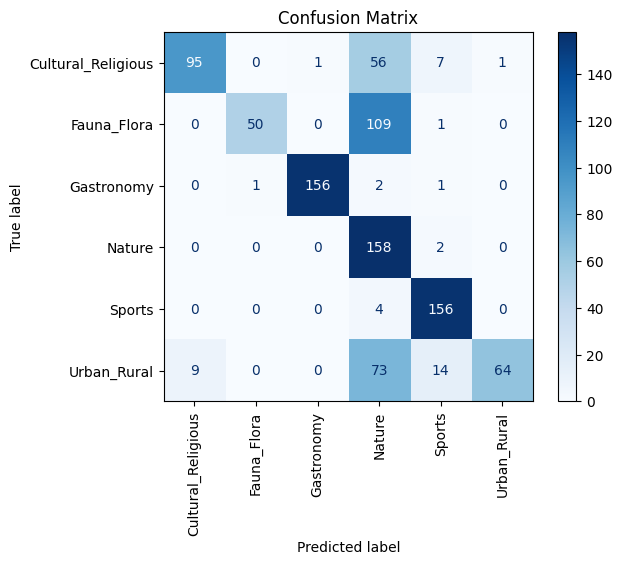

[0.59375 0.3125  0.975   0.9875  0.975   0.4    ]


In [24]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

In [1]:
classes = ",".join(label2id.keys())
results = ",".join([str(round(acc*100, 2)) for acc in cm.diagonal()])

NameError: name 'label2id' is not defined